In [1]:
import numpy as np
import pyuvdata
from newcal import (
    caldata,
    calibration_wrappers,
    calibration_optimization,
    cost_function_calculations,
)
import matplotlib.pyplot as plt
import importlib
importlib.reload(caldata)
importlib.reload(calibration_wrappers)
importlib.reload(calibration_optimization)
importlib.reload(cost_function_calculations)

<module 'newcal.cost_function_calculations' from '/usr/local/miniconda3/envs/py310/lib/python3.10/site-packages/newcal/cost_function_calculations.py'>

In [2]:
THIS_DIR = "/home/rbyrne/newcal/newcal"

In [3]:
test_freq_ind = 0
test_pol_ind = 0
delta_val = 1e-8
amplitude_perturbation = 1.3
use_Nfreqs = 3

In [4]:
# Get data
model = pyuvdata.UVData()
model.read(f"{THIS_DIR}/data/test_model_1freq.uvfits")
data = pyuvdata.UVData()
data.read(f"{THIS_DIR}/data/test_data_1freq.uvfits")

data_copy = data.copy()
model_copy = model.copy()
for ind in range(1, use_Nfreqs):
    data_copy.freq_array += 1e6
    model_copy.freq_array += 1e6 * ind
    data.fast_concat(data_copy, "freq", inplace=True)
    model.fast_concat(model_copy, "freq", inplace=True)

# Added for debugging
data.select(polarizations=[-5], blt_inds=[0, 1], inplace=True)
model.select(polarizations=[-5], blt_inds=[0, 1], inplace=True)

caldata_obj = caldata.CalData()
caldata_obj.load_data(data, model)

caldata_obj.visibility_weights[:, :, :, :] = 1  # Unflag all


Combined frequencies are separated by more than their channel width. This will make it impossible to write this data out to some file types.
Combined frequencies are separated by more than their channel width. This will make it impossible to write this data out to some file types.
Combined frequencies are separated by more than their channel width. This will make it impossible to write this data out to some file types.
Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


In [5]:
caldata_obj.dwcal_inv_covariance = np.random.rand(
    caldata_obj.Ntimes,
    caldata_obj.Nbls,
    caldata_obj.Nfreqs,
    caldata_obj.Nfreqs,
    caldata_obj.N_vis_pols,
) + 1j * np.random.rand(
    caldata_obj.Ntimes,
    caldata_obj.Nbls,
    caldata_obj.Nfreqs,
    caldata_obj.Nfreqs,
    caldata_obj.N_vis_pols,
)
caldata_obj.dwcal_inv_covariance = np.transpose(
    np.matmul(
        np.transpose(caldata_obj.dwcal_inv_covariance, axes=(0, 1, 4, 2, 3)),
        np.conj(np.transpose(caldata_obj.dwcal_inv_covariance, axes=(0, 1, 4, 3, 2))),
    ),
    axes=(0, 1, 3, 4, 2),
)  # Enforce that the matrix is Hermitian

In [6]:
amp_terms_1 = np.copy(caldata_obj.abscal_params[0, :, test_pol_ind])
amp_terms_1[test_freq_ind] += delta_val / 2
print(amp_terms_1)
amp_terms_2 = np.copy(caldata_obj.abscal_params[0, :, test_pol_ind])
amp_terms_2[test_freq_ind] -= delta_val / 2
print(amp_terms_2)

cost1 = cost_function_calculations.cost_function_dw_abscal(
    amp_terms_1,
    caldata_obj.abscal_params[1:, :, test_pol_ind],
    caldata_obj.model_visibilities[:, :, :, test_pol_ind],
    caldata_obj.data_visibilities[:, :, :, test_pol_ind],
    caldata_obj.uv_array,
    caldata_obj.visibility_weights[:, :, :, test_pol_ind],
    caldata_obj.dwcal_inv_covariance[:, :, :, :, test_pol_ind],
)
cost0 = cost_function_calculations.cost_function_dw_abscal(
    amp_terms_2,
    caldata_obj.abscal_params[1:, :, test_pol_ind],
    caldata_obj.model_visibilities[:, :, :, test_pol_ind],
    caldata_obj.data_visibilities[:, :, :, test_pol_ind],
    caldata_obj.uv_array,
    caldata_obj.visibility_weights[:, :, :, test_pol_ind],
    caldata_obj.dwcal_inv_covariance[:, :, :, :, test_pol_ind],
)

amp_jac, phase_jac = cost_function_calculations.jacobian_dw_abscal(
    caldata_obj.abscal_params[0, :, test_pol_ind],
    caldata_obj.abscal_params[1:, :, test_pol_ind],
    caldata_obj.model_visibilities[:, :, :, test_pol_ind],
    caldata_obj.data_visibilities[:, :, :, test_pol_ind],
    caldata_obj.uv_array,
    caldata_obj.visibility_weights[:, :, :, test_pol_ind],
    caldata_obj.dwcal_inv_covariance[:, :, :, :, test_pol_ind],
)

grad_approx = (cost1 - cost0) / delta_val

print(f"Gradient approximation value: {grad_approx}")
print(f"Jacobian value: {amp_jac[test_freq_ind]}")

[1. 1. 1.]
[1. 1. 1.]
DWAbscal cost: 0.5108710843861584
DWAbscal cost: 0.5108684080718852
Gradient approximation value: 267.63142731978104
Jacobian value: 267.63142955772696


In [7]:
for amp_val in [1-delta_val/2, 1+delta_val/2]:
    use_amps = np.array([amp_val, 1, 1])
    cost = cost_function_calculations.cost_function_dw_abscal(
        use_amps,
        caldata_obj.abscal_params[1:, :, test_pol_ind],
        caldata_obj.model_visibilities[:, :, :, test_pol_ind],
        caldata_obj.data_visibilities[:, :, :, test_pol_ind],
        caldata_obj.uv_array,
        caldata_obj.visibility_weights[:, :, :, test_pol_ind],
        caldata_obj.dwcal_inv_covariance[:, :, :, :, test_pol_ind],
    )
    print(cost)

DWAbscal cost: 0.5108684080718852
0.5108684080718852
DWAbscal cost: 0.5108710843861584
0.5108710843861584


In [8]:
res_vec = (caldata_obj.data_visibilities-caldata_obj.model_visibilities).flatten()
print(res_vec)

[-0.00899124+0.17314911j -0.00899124+0.17314911j -0.00899124+0.17314911j]


In [9]:
cov_mat = caldata_obj.dwcal_inv_covariance[0,0,:,:,0]
print(cov_mat)

[[1.7205388 +0.j         1.76116475+0.26755059j 1.60215397+0.55494699j]
 [1.76116475-0.26755059j 3.00228843+0.j         1.7554046 +0.90115489j]
 [1.60215397-0.55494699j 1.7554046 -0.90115489j 2.03390436+0.j        ]]


In [10]:
cost_estimated = np.einsum("i,ij,j", np.conj(res_vec), cov_mat, res_vec)
print(cost_estimated)

(0.5108697462280314+6.5052130349130266e-18j)


In [11]:
cost = cost_function_calculations.cost_function_dw_abscal(
    caldata_obj.abscal_params[0, :, test_pol_ind],
    caldata_obj.abscal_params[1:, :, test_pol_ind],
    caldata_obj.model_visibilities[:, :, :, test_pol_ind],
    caldata_obj.data_visibilities[:, :, :, test_pol_ind],
    caldata_obj.uv_array,
    caldata_obj.visibility_weights[:, :, :, test_pol_ind],
    caldata_obj.dwcal_inv_covariance[:, :, :, :, test_pol_ind],
)
print(cost)

DWAbscal cost: 0.5108697462280314
0.5108697462280314


In [12]:
jac_estimated = (
    4
    * np.real(np.conj(caldata_obj.data_visibilities.flatten())
    * np.einsum("ij,j", cov_mat, res_vec)
))
print(jac_estimated)

[267.63142956 336.25685592 245.57044723]


In [13]:
jac_estimated = (
    2
    * np.conj(caldata_obj.data_visibilities.flatten())
    * np.einsum("ij,j", cov_mat, res_vec)
) + (
    2
    * caldata_obj.data_visibilities.flatten()
    * np.einsum("ij,j", np.conj(cov_mat), np.conj(res_vec))
)
print(jac_estimated)

[267.63142956+0.j 336.25685592+0.j 245.57044723+0.j]


In [14]:
jac = cost_function_calculations.jacobian_dw_abscal(
    caldata_obj.abscal_params[0, :, test_pol_ind],
    caldata_obj.abscal_params[1:, :, test_pol_ind],
    caldata_obj.model_visibilities[:, :, :, test_pol_ind],
    caldata_obj.data_visibilities[:, :, :, test_pol_ind],
    caldata_obj.uv_array,
    caldata_obj.visibility_weights[:, :, :, test_pol_ind],
    caldata_obj.dwcal_inv_covariance[:, :, :, :, test_pol_ind],
)
print(jac)

(array([267.63142956, 336.25685592, 245.57044723]), array([[1154.07214419, 2052.5061495 , 4390.71006614],
       [  92.7582295 ,  164.96961428,  352.90210759]]))


In [15]:
avg_spectra = np.load(
    "/safepool/rbyrne/hera_abscal_Jun2024/mean_variance_abscal_nbins200_xx.npz"
)
delay_spectrum_variance = avg_spectra["variance"]
bl_length_bin_edges = avg_spectra["bl_bin_edges"]
delay_axis = avg_spectra["delay_array"]

data_path = "/safepool/rbyrne/hera_data/H6C-data/2459861/zen.2459861.45004.sum.abs_calibrated.red_avg.uvh5"
model_path = "/safepool/rbyrne/hera_data/interpolated_models/zen.2459861.45004.sum.abs_calibrated.red_avg_model.uvfits"
data = pyuvdata.UVData()
data.read(data_path)
model = pyuvdata.UVData()
model.read(model_path)
data.select(frequencies=data.freq_array[0:200])
model.select(frequencies=model.freq_array[0:200])

data.inflate_by_redundancy(use_grid_alg=True)
model.inflate_by_redundancy(use_grid_alg=True)

# Model does not include all baselines
model_baselines = list(set(list(zip(model.ant_1_array, model.ant_2_array))))
data_baselines = list(set(list(zip(data.ant_1_array, data.ant_2_array))))
use_baselines = [
    baseline
    for baseline in model_baselines
    if (baseline in data_baselines) or (baseline[::-1] in data_baselines)
]
use_polarizations = -5  # Use XX only
data.select(bls=use_baselines, polarizations=use_polarizations)
model.select(bls=use_baselines, polarizations=use_polarizations)

# Align phasing
data.phase_to_time(np.mean(data.time_array))
model.phase_to_time(np.mean(data.time_array))

data.compress_by_redundancy()
model.compress_by_redundancy()

Missing some redundant groups. Filling in available data.
Missing some redundant groups. Filling in available data.


In [16]:
initial_abscal_params = np.zeros((3, data.Nfreqs, 1))
initial_abscal_params[0, :, 0] = np.random.normal(1.0, scale=0.1, size=(data.Nfreqs))
initial_abscal_params[1, :, 0] = np.random.normal(0.0, scale=0.01, size=(data.Nfreqs))
initial_abscal_params[2, :, 0] = np.random.normal(0.0, scale=0.01, size=(data.Nfreqs))

In [17]:
# Run DWAbscal
dwabscal_params = calibration_wrappers.dw_absolute_calibration(
    data,
    data,
    #np.ones_like(delay_spectrum_variance),
    delay_spectrum_variance,
    bl_length_bin_edges,
    delay_axis,
    initial_abscal_params=initial_abscal_params,
    verbose=True,
    xtol=1e-6,
    maxiter=50,
)

print(dwabscal_params)

Reading data...
Formatting data...


Done. Data formatting time 0.002281030019124349 minutes.
Calculating delay weighting matrix...


invalid value encountered in divide


Done. Time calculating delay weighting matrix 0.026711440086364745 minutes.
Running calibration optimization...
DWAbscal cost: 9574792492.956146
Initial cost: 9574792492.956146
DWAbscal cost: 9574792492.956146
DWAbscal cost: 21479868913.217186
DWAbscal cost: 14706786881.150011
DWAbscal cost: 4357319408.319301
DWAbscal cost: 4862259180.917555
DWAbscal cost: 1959245408.7117147
DWAbscal cost: 2810966481.2121634
DWAbscal cost: 1538841486.0464473
DWAbscal cost: 1017335355.1692748
DWAbscal cost: 799118851.0102643
DWAbscal cost: 744636708.735757
DWAbscal cost: 639502757.3802652
DWAbscal cost: 315186638.76330644
DWAbscal cost: 46396490.47738092
DWAbscal cost: 45008265.198440924
DWAbscal cost: 42256508.90479131
DWAbscal cost: 32301090.99846635
DWAbscal cost: 12918806.180707505
DWAbscal cost: 7648132.07925703
DWAbscal cost: 1642169.4258548922
DWAbscal cost: 1393557.4890854387
DWAbscal cost: 1355270.3295414983
DWAbscal cost: 1279293.2533751922
DWAbscal cost: 1002670.8851753309
DWAbscal cost: 4482

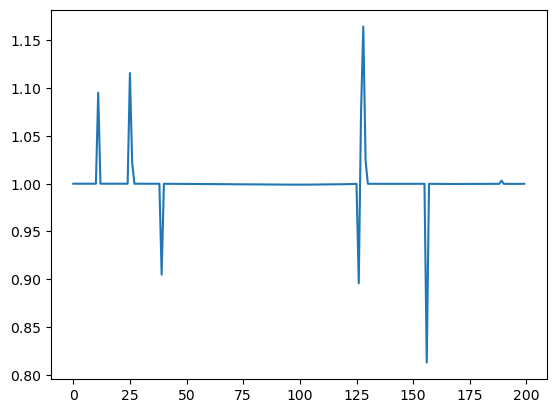

In [18]:
plt.plot(dwabscal_params[0, :, 0])

In [19]:
print(dwabscal_params[0, :, 0])

[1.00000896 0.99996657 1.00001832 0.99999428 0.99997366 1.00000955
 1.00000734 0.9999674  1.00002163 0.99999106 0.99999725 1.09519278
 1.00001978 0.99998981 0.99999984 0.99996757 1.00004702 0.99993274
 0.99999473 1.0000362  0.99993398 1.00000758 0.99999515 0.99998233
 0.99999837 1.11582945 1.02180439 0.99996459 1.00002716 0.9999435
 1.00000682 0.99994873 0.99999918 0.99994753 0.99998389 0.99996823
 0.99997188 0.99997451 0.99997599 0.90482099 0.99995044 0.99993723
 0.99990918 0.9998992  0.99988032 0.99986943 0.99984826 0.99984275
 0.99983469 0.99982004 0.99981998 0.99981383 0.9998081  0.99980852
 0.99980416 0.99979515 0.99977713 0.99976818 0.99976665 0.9997734
 0.99976483 0.99975137 0.99973778 0.99973357 0.99971583 0.99969118
 0.99965757 0.99961853 0.99957341 0.99953849 0.99950063 0.99947684
 0.99944475 0.9994133  0.99940145 0.99937846 0.99936112 0.99933999
 0.99932589 0.99931808 0.99930762 0.99930204 0.99929868 0.99927735
 0.99924391 0.99922573 0.99918309 0.99916663 0.99912713 0.999107

In [20]:
data_perturbed = data.copy()
data_perturbed.data_array[:, 0:100, :] *= 1.2
dwabscal_perturbed_params = calibration_wrappers.dw_absolute_calibration(
    data_perturbed,
    data,
    np.ones_like(delay_spectrum_variance),
    bl_length_bin_edges,
    delay_axis,
    initial_abscal_params=initial_abscal_params,
    verbose=True,
    xtol=1e-6,
    maxiter=50,
)

Reading data...
Formatting data...
Done. Data formatting time 0.0023107647895812987 minutes.
Calculating delay weighting matrix...


invalid value encountered in divide


Done. Time calculating delay weighting matrix 0.026727227369944255 minutes.
Running calibration optimization...
DWAbscal cost: 1356338623.5606906
Initial cost: 1356338623.5606906
DWAbscal cost: 1356338623.5606906
DWAbscal cost: 52890716.6481098
DWAbscal cost: 1258193.9794797401
DWAbscal cost: 399630.3206374421
DWAbscal cost: 384358.0765030152
DWAbscal cost: 354138.14435574616
DWAbscal cost: 245848.13149852835
DWAbscal cost: 46721.162364122356
DWAbscal cost: 264.6341832644902
DWAbscal cost: 245.19635237827347
Optimization terminated successfully.
         Current function value: 245.196352
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10
         Hessian evaluations: 8
Optimization terminated successfully.
Optimization time: 1.129162073135376 minutes
DWAbscal cost: 245.19635237827347
Final cost: 245.19635237827347
Done. Optimization time: 200 frequency channels in 1.1378397822380066 minutes
Total processing time 1.1645937442779541 minutes.


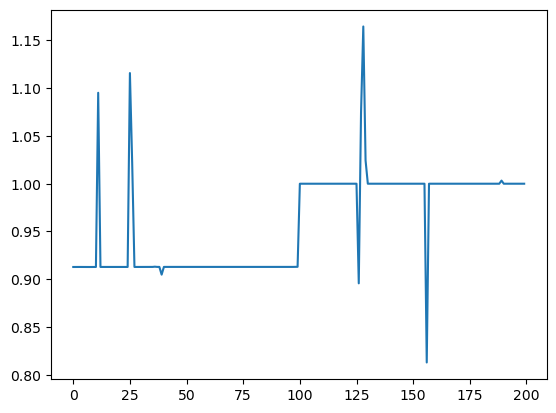

In [21]:
plt.plot(dwabscal_perturbed_params[0, :, 0])

In [25]:
initial_abscal_params = np.zeros((3, data.Nfreqs, 1))
initial_abscal_params[0, :, 0] = np.random.normal(1.0, scale=0.1, size=(data.Nfreqs))
initial_abscal_params[1, :, 0] = np.random.normal(0.0, scale=0.01, size=(data.Nfreqs))
initial_abscal_params[2, :, 0] = np.random.normal(0.0, scale=0.01, size=(data.Nfreqs))
dwabscal_perturbed_params_weighted = calibration_wrappers.dw_absolute_calibration(
    data_perturbed,
    data,
    #np.ones_like(delay_spectrum_variance),
    delay_spectrum_variance,
    bl_length_bin_edges,
    delay_axis,
    initial_abscal_params=initial_abscal_params,
    verbose=True,
    xtol=1e-6,
    maxiter=50,
)

Reading data...
Formatting data...
Done. Data formatting time 0.002386371294657389 minutes.
Calculating delay weighting matrix...


invalid value encountered in divide


Done. Time calculating delay weighting matrix 0.026407865683237712 minutes.
Running calibration optimization...
DWAbscal cost: 11041119335.067434
Initial cost: 11041119335.067434
DWAbscal cost: 11041119335.067434
DWAbscal cost: 24473837261.74523
DWAbscal cost: 22757667580.231182
DWAbscal cost: 6710737012.530937
DWAbscal cost: 4171378417.5726347
DWAbscal cost: 1940806254.336973
DWAbscal cost: 1381133498.9247
DWAbscal cost: 1166396136.3365664
DWAbscal cost: 1033573914.2299653
DWAbscal cost: 912432133.6372766
DWAbscal cost: 690362117.7430955
DWAbscal cost: 336945775.3877813
DWAbscal cost: 57902451.489015855
DWAbscal cost: 56109301.51549561
DWAbscal cost: 52562966.171040446
DWAbscal cost: 39896294.66019463
DWAbscal cost: 16328363.761037018
DWAbscal cost: 5245494.283115971
DWAbscal cost: 5033305.178626311
DWAbscal cost: 4622817.018267077
DWAbscal cost: 3341766.898041595
DWAbscal cost: 1085037.5408999256
DWAbscal cost: 1023283.4473302985
DWAbscal cost: 921882.6152673394
DWAbscal cost: 730096

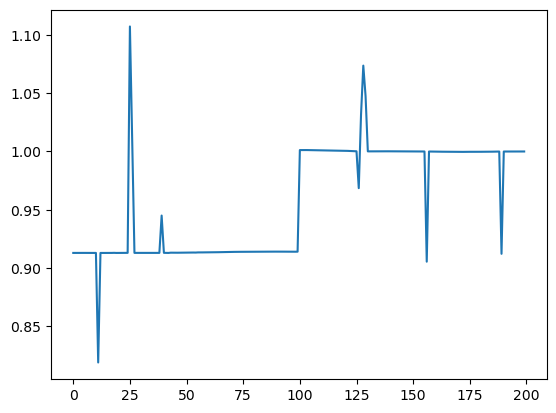

In [26]:
plt.plot(dwabscal_perturbed_params_weighted[0, :, 0])

In [22]:
def newtons_method_optimizer(
    x0,
    caldata_obj,
    step_size=0.1,
    covergence_condition=0.001,
    maxiters=100,
):

    n_iters = 0
    convergence_iters = 0
    while convergence_iters < 3 and n_iters <= maxiters:
        hess_mat = calibration_optimization.hessian_dw_abscal_wrapper(
            x0, list(range(caldata_obj.Nfreqs)), caldata_obj
        )
        hess_mat_inv = np.linalg.inv(hess_mat)
        del hess_mat
        jac = calibration_optimization.jacobian_dw_abscal_wrapper(
            x0,
            list(range(caldata_obj.Nfreqs)),
            caldata_obj,
        )
        x1 = x0 - step_size * np.matmul(hess_mat_inv, jac)
        del hess_mat_inv
        del jac
        cost = calibration_optimization.cost_dw_abscal_wrapper(
            x0,
            list(range(caldata_obj.Nfreqs)),
            caldata_obj,
        )
        print(f"Iteration {n_iters}, cost func value: {cost}")
        check_conv = np.max(np.abs(x1 - x0))
        if check_conv < covergence_condition:
            convergence_iters += 1
        else:
            convergence_iters = 0
        x0 = x1
        n_iters += 1

    return x1